In [184]:
import os
from typing import List, Tuple

from pydub import AudioSegment
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
import whisper

Download GTZAN dataset from `https://huggingface.co/datasets/marsyas/gtzan/resolve/main/data/genres.tar.gz` and add uncompressed result to `data/` folder

In [14]:
labels_map = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9,
}

In [15]:
DATA_DIR = "data"

In [64]:
annotations = []
for label in labels_map:
    for file in os.listdir(f"{DATA_DIR}/genres/{label}"):
        annotation = {
            "filepath": f"{DATA_DIR}/genres/{label}/{file}",
            "label": labels_map[label]
        }
        annotations.append(annotation)

Each original audio sample is sliced into _SAMPLE_SLICES sub-samples

In [171]:
class CustomGTZANDataset(Dataset):
    _SAMPLE_SLICES = 10
    _TRAIN_FRAC = 0.9

    def __init__(self, annotations: List, train: bool):
        frac = self._TRAIN_FRAC if train else (1.0 - self._TRAIN_FRAC)
        self._annotations = (
            pd.DataFrame(annotations)
            .groupby("label")
            .apply(lambda df: df.sample(frac=frac, replace=False, random_state=123))
            .reset_index(drop=True)
            .to_dict(orient="records")
        )

    def __len__(self):
        return len(self._annotations) * self._SAMPLE_SLICES

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        audio_path = self._annotations[idx % len(self._annotations)]["filepath"]

        t = idx // len(self._annotations)
        milliseconds = 30000 / self._SAMPLE_SLICES
        audio_segment = AudioSegment.from_wav(audio_path)[
            milliseconds * t: milliseconds * t + milliseconds
        ]
        # temporarily write to disk
        audio_segment.export("tmp.wav", format="wav")
        waveform, sample_rate = torchaudio.load("tmp.wav")
        os.remove("tmp.wav")

        label = self._annotations[idx % len(self._annotations)]["label"]
        return whisper.log_mel_spectrogram(waveform), label

In [172]:
train_dataset = CustomGTZANDataset(annotations=annotations, train=True)

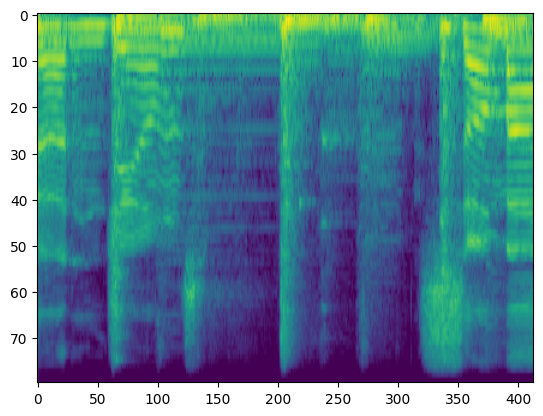

Log Mel Spectrogram example of class 0


In [166]:
img = train_dataset[0][0].squeeze(0)
plt.imshow(img, aspect="auto")
plt.show()
print(f"Log Mel Spectrogram example of class {train_dataset[0][1]}")

data/genres/disco/disco.00083.wav


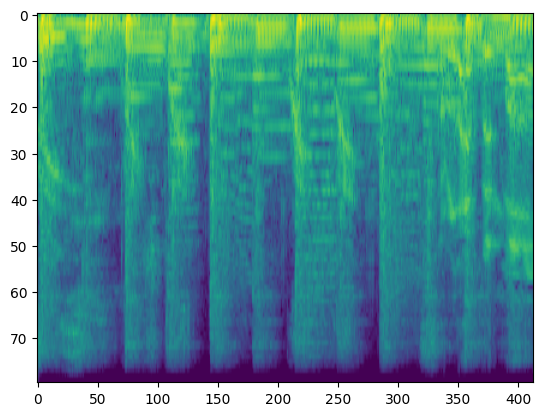

data/genres/disco/disco.00083.wav
Log Mel Spectrogram example of class 3


In [183]:
img = train_dataset[3000][0].squeeze(0)
plt.imshow(img, aspect="auto")
plt.show()
print(f"Log Mel Spectrogram example of class {train_dataset[3000][1]}")